# <font size=5, color='black'> Setting up </font>

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import os
import scipy
from scipy.optimize import fsolve
from scipy.fft import fft, fftfreq
from scipy.integrate import trapezoid
from scipy.signal import savgol_filter
import pandas as pd
from qutip import *
import time

In [6]:
# constants
ABSORPTION_LIMIT = 5.0
SPECIAL_CHARACTERS = "!@#$%^&*()-+?_=,<>/"

# physics constants
hbar = 1.05457182*10**(-34) # Js
me = 9.1093837015e-31    # electron mass
mn = 1.67493e-27         # neutron mass
eC = 1.60218e-19         # electric charge
muB = eC*hbar/(2*me)     # Bohr magneton

# Lithium constants
mLi6 = 9.9883414*10**(-27) # kg
Li6D2Gamma = 5.8724e6 # Hz Note that this is NOT angular freq
Li6D2lambda0 = 670.977338*10**(-9) # meters
Li6D2sigma0 = 3*(Li6D2lambda0)**2/(2*np.pi)
Li6Ahf_s12 = 152.1368407e6  # This is NOT angular freq
Li6Bhf_s12 = 0
Li6Ahf_p12 = 17.386e6 # Hz
Li6Bhf_p12 = 0
Li6Ahf_p32 = -1.155e6 # Hz
Li6Bhf_p32 = -0.10e6 # Hz
Li6I = 1
Li6gI = -0.0004476540

# Sodium-23 constants
mNa23 = 0.38175403519e25 # kg
Na23D2Gamma = 9.794646e6 # Hz
Na23D2lambda0 = 589.158326415e-9 # meters
Na23D2sigma0 = 3*(Na23D2lambda0)**2/(2*np.pi)
Na23Ahf_s12 = 885.8130644050e6 # Hz
Na23Bhf_s12 = 0e6 # Hz
Na23Ahf_p12 = 94.4413e6 # Hz
Na23Bhf_p12 = 0e6 # Hz
Na23Ahf_p32 = 18.53415e6 # Hz
Na23Bhf_p32 = 2.72430e6 # Hz
Na23I = 3/2
Na23gI = -0.0008046108080

# Potassium-40 constants
mK40 = 39.9639984821*1.6605402e-27 # kg 
K40D2Gamma = 6.03511 # MHz
K40D2lambda0 = 766.700674872173e-9 # meters
K40D2sigma0 = 3*(K40D2lambda0)**2/(2*np.pi)
K40Ahf_s12 = -285.730824e6 # Hz
K40Bhf_s12 = 0
K40Ahf_p12 = -34.52325e6 # Hz
K40Bhf_p12 = 0
K40Ahf_p32 = -7.58510e6 # Hz
K40Bhf_p32 = -3.44590e6 # Hz
K40I = 4
K40gI = 0.00017649034


# <font size=5, color='black'> Zeeman Effect Calculator </font>

In [2]:
# helper functions
def A_hfs(J, I, mj, mi, mjj, mii):
    Ahfs = 0
    if (mj == mjj) and (mi == mii):
        Ahfs = mj*mi
    elif (mj == mjj + 1.0) and (mi == mii - 1.0):
        Ahfs = (1/2)*np.sqrt((J+mj)*(J-mj+1)*(I-mi)*(I+mi+1))
    elif (mj == mjj - 1.0) and (mi == mii + 1.0): 
        Ahfs = (1/2)*np.sqrt((J-mj)*(J+mj+1)*(I+mi)*(I-mi+1))
    else:
        Ahfs = 0
    return Ahfs

def B_hfs(J, I, mj, mi, mjj, mii):
    # reference: N. Ramsey's Molecular Beams... some Appendix, I believe
    Bhfs = 0
    if (mj == mjj) and (mi == mii):
        Bhfs = (1/2)*(3*mi**2-I*(I+1))*(3*mj**2-J*(J+1))
    elif (mj == mjj - 1) and (mi == mii + 1):   
        Bhfs = (3/4)*(2*mjj-1)*(2*mii+1)*np.sqrt((J+mjj)*(J-mjj+1)*(I-mii)*(I+mii+1))
    elif mj == mjj + 1 and mi == mii - 1:
        Bhfs = (3/4)*(2*mjj+1)*(2*mii-1)*np.sqrt((J-mjj)*(J+mjj+1)*(I+mii)*(I-mii+1))
    elif mj == mjj - 2 and mi == mii + 2 :  
        Bhfs = (3/4)*np.sqrt((J+mjj)*(J+mjj-1)*(J-mjj+1)*(J-mjj+2)*(I-mii)*(I-mii-1)*(I+mii+1)*(I+mii+2))
    elif mj == mjj + 2 and mi == mii - 2:
        Bhfs = (3/4)*np.sqrt((J-mjj)*(J-mjj-1)*(J+mjj+1)*(J+mjj+2)*(I+mii)*(I+mii-1)*(I-mii+1)*(I-mii+2))
    else:
        Bhfs = 0

    if (2*I*(2*I-1)*J*(2*J-1)) != 0:
        Bhfs = Bhfs/(2*I*(2*I-1)*J*(2*J-1))
    return Bhfs

def mag(B, J, L, S, mj, mi, mjj, mii, gI):
    gL = 1 - me/mn           # gyro magnetic factor of the orbital
    gS = 2.0023193043622     # electron spin g-factor
    gJ = gL*(J*(J+1)-S*(S+1)+L*(L+1))/(2*J*(J+1)) + gS*(J*(J+1)+S*(S+1)-L*(L+1))/(2*J*(J+1)) # verified, correct :)
    
    mag = 0
    if mj == mjj and mi == mii:
        mag = (muB/hbar)*(gJ*mj + gI*mi)*B*1e-4 # B is in Gauss, need to convert to Tesla
    else:
        mag = 0

    return mag/(2*np.pi) # return answer in Hz

In [3]:
# zeeman splitting calculator
def zeeman_splitting_calculator(J, I, gI, L, S, B_main, B_start, B_end, num_B, Ahf, Bhf = 0, 
                                plotting = True, highlight_HF_states = [0,0], plot_range = None, 
                                single_B_field_calc_mode = False, print_field_sensitivity_between = None,
                                search_mode = False, splitting = 0, splitting_between_states = None):

    B_start = min(B_start, B_end)
    B_end = max(B_start, B_end)
    if num_B >= 20:
        B_fields = np.linspace(B_start, B_end, num_B)
        if B_main < max(B_fields) and B_main > min(B_fields):
            B_fields = np.append(B_fields, B_main)
            B_fields = np.sort(B_fields)
        else:
            print('The variable "B_main" is not in B fields!')
            return 0        
    else:
        print('Number of points must exceed 20!')
        return 0
    
    # possible Js
    possible_Js = np.arange(abs(L-S), abs(L+S)+1, 1)
    if J > max(possible_Js) or J < min(possible_Js):
        print('Invalid J!')
        return 0
    mJ = np.linspace(-J, J, int(2*J+1))
    mI = np.linspace(-I, I, int(2*I+1))

    # now make a basis:
    basis = [] # which is the set {[mj, mi]}
    for mj in mJ:
        for mi in mI:
            basis.append([mj, mi])
    size = len(basis)
    H = np.empty((size,size))
    list_of_freqs = [ ]

    # generate the zeeman Hamiltonian and diagonalize it 
    for b in B_fields:
        for r in range(size):
            mj = basis[r][0]
            mi = basis[r][1]
            for c in range(size):
                mjj = basis[c][0]
                mii = basis[c][1]
                H[r,c] = Ahf * A_hfs(J, I, mj, mi, mjj, mii) + Bhf * B_hfs(J, I, mj, mi, mjj, mii) + mag(b, J, L, S, mj, mi, mjj, mii, gI)
        freqs, eigenvectors = np.linalg.eigh(H, UPLO='L') # calculate using the lower triangular part, can also do eig() -- same result
        freqs = freqs * 1e-6
        list_of_freqs.append(freqs)

    # Plotting and returning statistics:
    list_of_freqs = np.array(list_of_freqs)
    list_of_freqs = np.sort(list_of_freqs, axis=1)    
    highlight_HF_states = np.array(highlight_HF_states)
    if plotting:
        for s in range(size):
            plt.plot(B_fields, list_of_freqs[:,s], linewidth = 0.5, color='red')
        if highlight_HF_states.all() in np.arange(1, size+1,1):
            for state in highlight_HF_states:
                plt.plot(B_fields[np.where((B_fields == B_main))[0][0]:], 
                         list_of_freqs[np.where((B_fields == B_main))[0][0] : , state-1], linewidth = 1.5 , color = 'black')
        if plot_range is not None:
            plt.ylim(plot_range)
        plt.xlabel('Magnetic field (G)')
        plt.ylabel('Energy shift (MHz)')
        plt.grid()
        plt.show()   

    # Compute relevant statistics:
    if single_B_field_calc_mode:
        print('Frequency spacings (MHz), from low to high in state energy, at ' + str(B_main) +  ' G:')
        freqs = list_of_freqs[np.where(B_fields == B_main)[0][0]]
        for i in range(len(freqs)-1):
            print("{:.4f}".format(freqs[i+1] - freqs[i]))    
        print(' ')    
        # Field sensitivities:
        print('Field sensitivity of shift (MHz per G), from low to high in state energy, at ' + str(B_main) + ' G:')
        freqs_next = list_of_freqs[np.where(B_fields == B_main)[0][0] + 1]
        freqs_diff = freqs_next - freqs
        Bs_diff = B_fields[np.where(B_fields == B_main)[0][0] + 1] - B_fields[np.where(B_fields == B_main)[0][0]]
        for i in range(len(freqs)):
            print("{:.3f}".format(freqs_diff[i] / Bs_diff))  
        print(' ')

        # Next, calculate the difference between in energy between the two states:
        if print_field_sensitivity_between is not None:
            lower_state  = list_of_freqs[ : , print_field_sensitivity_between[0]-1]
            higher_state = list_of_freqs[ : , print_field_sensitivity_between[1]-1]
            differential_shift =  higher_state - lower_state
            # take derivative:
            dfdB = np.diff(differential_shift)/np.diff(B_fields)
            print( 'Field sensitivity of splitting, df'+str(print_field_sensitivity_between[1])+str(print_field_sensitivity_between[0])+' by dB:')   
            print("{:.4f}".format(dfdB[np.where((B_fields == B_main))[0][0]]) + ' MHz per G')

    # Search for B_field that matches splitting:
    if search_mode:
        if splitting_between_states is not None:
            state_A_freqs = list_of_freqs[ : , splitting_between_states[0]-1]
            state_B_freqs = list_of_freqs[ : , splitting_between_states[1]-1]
            AB_freq_differences = np.abs(state_B_freqs - state_A_freqs - splitting) # assuming no weird crossings...
            AB_freq_diff_min_index = np.argmin(AB_freq_differences)

            print(' ')
            print('Closest B field (G): ' + "{:.2f}".format(B_fields[AB_freq_diff_min_index]))
            splitting_error = state_B_freqs[AB_freq_diff_min_index] - state_A_freqs[AB_freq_diff_min_index] - splitting
            print('Splitting Error (MHz): ' + "{:.5f}".format(splitting_error ))
            if np.abs(splitting_error/splitting) >= 0.1: # if error is too big
                print('Note: large error might due to bad guesses!')

    return 

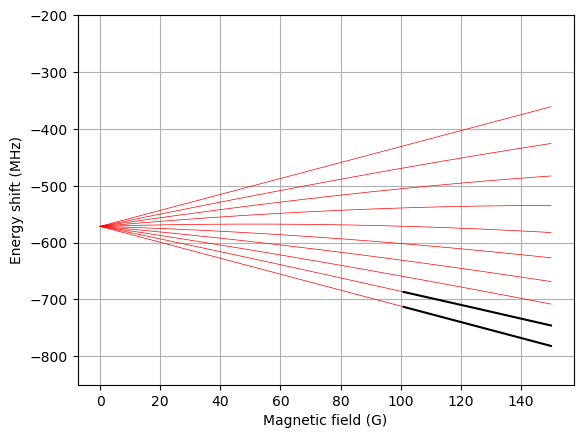

Frequency spacings (MHz), from low to high in state energy, at 101 G:
26.2370
27.1763
28.2244
29.4041
30.7456
32.2896
34.0927
36.2370
38.8456
1041.5567
36.1871
34.0428
32.2397
30.6957
29.3542
28.1745
27.1264
 
Field sensitivity of shift (MHz per G), from low to high in state energy, at 101 G:
-1.402
-1.186
-0.956
-0.710
-0.443
-0.153
0.167
0.525
0.931
1.402
-0.929
-0.524
-0.167
0.153
0.443
0.709
0.955
1.185
 
Field sensitivity of splitting, df21 by dB:
0.2158 MHz per G
 
Closest B field (G): 101.08
Splitting Error (MHz): 0.00031


In [14]:
# Zeeman calculator cell
B_start = 0
B_end = 150
B_main = 101 # G
num_B = 10000

# Careful what you type in here!
Ahf = K40Ahf_s12
Bhf = K40Bhf_s12
L = 0
S = 1/2
J = 1/2
I = K40I
gI = K40gI

zeeman_splitting_calculator(J, I, gI, L, S, B_main, B_start, B_end, num_B, Ahf, Bhf, 
                            plotting = True, highlight_HF_states = [1,2], plot_range = [-850,-200], 
                            single_B_field_calc_mode = True, print_field_sensitivity_between = [1,2],
                            search_mode = True, splitting = 26.254, splitting_between_states = [1,2])

# <font size=5, color='black'> Rabi Solution for Two-Level System </font>

In [131]:
def _P2_Rabi(omega, tau, omegaR, omega0, offset):    
    OmegaR = np.sqrt( omegaR**2 + (omega - omega0)**2 )
    return ( omegaR**2 / OmegaR**2) * np.sin( 2*np.pi*OmegaR * tau / 2)**2 + offset

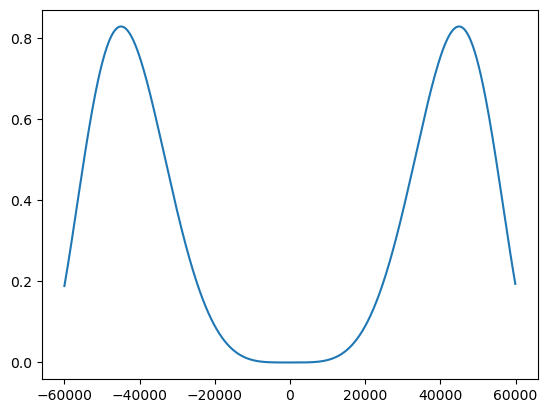

In [211]:
detunings = np.arange(-60e3,60e3,0.1e3)
omega0 = 26.2370e6
tau = 5e-5
omegaR = 10e3*10
offset = 0
P2 = _P2_Rabi(detunings+omega0, tau , omegaR, omega0, offset)
plt.plot(detunings, P2)
plt.show()

# <font size=5, color='black'> EIT </font>

In [387]:
# EIT solver
# Three-level system
# one: ground_1, two: ground_2, three: excited state
#       |3>
#      .   .
#     .      .
#    .        |2>
#  |1>
# (23)-transition is pump (control), (13)-transition is probe 

def EIT_solve(delta_31_list, delta_32, omega_13, omega_23, gamma_13, gamma_23, gamma_12):
    one, two, three = three_level_basis()
    sig11 = one * one.dag()
    sig22 = two * two.dag()
    sig33 = three * three.dag()
    sig13 = one * three.dag()
    sig23 = two * three.dag()
    sig12 = one * two.dag()

    # Collapse operators
    c_13 = np.sqrt(gamma_13)*sig13  # 1-3 coherence decay (probe transition)
    c_23 = np.sqrt(gamma_23)*sig23  # 2-3 coherence decay (pump transition)
    c_12 = np.sqrt(gamma_12)*sig12  # ground state coherence decay
    collapse = [c_13,c_23,c_12]

    rho_33 = [] # excited state population
    rho_31 = [] # ground-excited coherence
    chi = []

    for delta_31 in delta_31_list:
        # Define Hamiltonian for detuning Delta:
        H = (omega_13*(sig13+sig13.dag()) + omega_23*(sig23+sig23.dag()) + delta_32*(sig33 - sig22) + delta_31*(sig33 - sig11))
        
        # find steady-state density operator:
        rho_ss = steadystate(H,collapse)
        rho_33.append(rho_ss[2,2])  # save the exited state population
        rho_31.append(rho_ss[2,0])  # save the ground-excited coherence
        
        chi.append(expect(sig13.dag(), rho_ss)) 

    return (rho_33, chi)

In [415]:
# set up parameters and solve for excited state population and complex refractive index
gamma_13 = 0.1
gamma_23 = 5.0
gamma_12 = 0.05
delta_32 = 0.0
omega_13 = 0.1*gamma_23
omega_23 = 1.0*gamma_23
delta_31_list = np.linspace(-20,20,301)

rho_33, chi = EIT_solve(delta_31_list, delta_32, omega_13, omega_23, gamma_13, gamma_23, gamma_12)

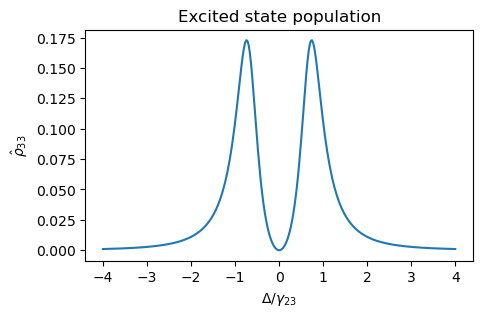

In [416]:
# excited state population vs (probe detuning/pump linewidth)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(delta_31_list/gamma_23,np.real(rho_33))
plt.title("Excited state population")
plt.xlabel("$\Delta/\gamma_{23}$")
plt.ylabel("$\hat{\\rho}_{33}$")
plt.show()

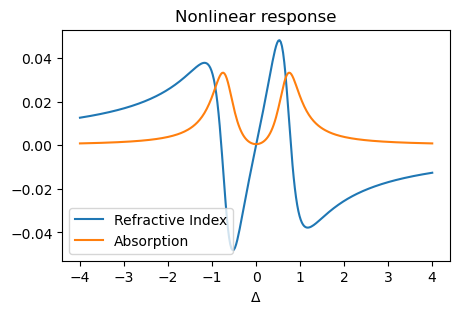

In [417]:
# absorption and refractive index
fig, ax = plt.subplots(figsize=(5,3))
plt.plot(delta_31_list/gamma_23,np.real(chi),label="Refractive Index")
plt.plot(delta_31_list/gamma_23,np.imag(chi),label="Absorption")
plt.legend()
plt.title("Nonlinear response")
plt.xlabel("$\Delta$")
plt.show()

# <font size=5, color='black'> STIRAP </font>

In [867]:
# three-level system
# |1> is the ground state molecule (tightly-bound)
# |2> is some excited state manifold
# |3> is the Feshbach molecule (weakly-bound)

def omegaR_upleg(t, args):
    t_center_upleg = args['t_center_upleg']
    omegaR = args['wR_upleg']
    # omegaR*np.heaviside(-t+(3/2)*t_center_upleg,1)*np.heaviside(t - t_center_upleg/2, 1)
    return omegaR*np.exp(-(t-t_center_upleg)**2/2e-12)

def omegaR_downleg(t, args):
    t_center_downleg = args['t_center_downleg']
    omegaR = args['wR_downleg']
    # return omegaR*np.heaviside(-t+(3/2)*t_center_downleg,1)*np.heaviside(t - t_center_downleg/2, 1)
    return omegaR*np.exp(-(t-t_center_downleg)**2/2e-12)

def STIRAP_solver(tlist, delta_downleg=0.0, delta_upleg=0.0, t_center_upleg=0.0, t_center_downleg=0.0, wR_upleg = 0.0, wR_downleg = 0.0):
    # Hamiltonian: 1: GS, 3: FB, 2: excited state
    one, two, three = three_level_basis()
    sig11 = one * one.dag()
    sig22 = two * two.dag()
    sig33 = three * three.dag()
    sig12 = one * two.dag()
    sig23 = two * three.dag()

    c_op_list = []
    
    H0 = delta_downleg * sig11 + 0*sig22 + delta_upleg * sig33
    H_upleg   = (sig12 + sig12.dag())/2.0 # pump
    H_downleg = (sig23 + sig23.dag())/2.0 # Stokes
    
    H = [H0, [H_upleg, omegaR_upleg], [H_downleg, omegaR_downleg]]
    # initially we're in the weakly-bound FB molecular state
    output = mesolve(H, three, tlist, c_op_list, [sig11, sig22, sig33], args={'t_center_upleg':t_center_upleg, 
                                                                              't_center_downleg': t_center_downleg, 
                                                                              'wR_upleg': wR_upleg, 
                                                                              'wR_downleg': wR_downleg})  
    p_GS_molecule = output.expect[0]
    p_excited_state = output.expect[1]
    p_FB_molecule = output.expect[2]

    return (p_GS_molecule, p_excited_state, p_FB_molecule)

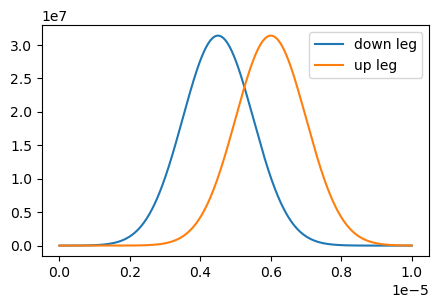

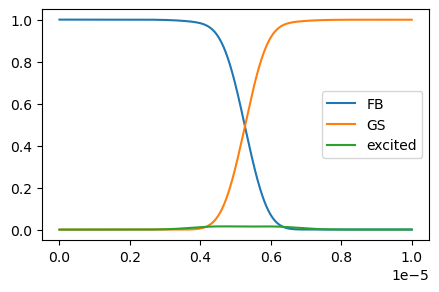

In [881]:
# calculate: dummy STIRAP system
tlist = np.linspace(0, 10e-6, 10000)
t_center_upleg = 6.0e-6
t_center_downleg = 4.5e-6
wR_upleg = 5e6 * 2 * np.pi
wR_downleg = 5e6 * 2 * np.pi

# plot the pulses
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(tlist, omegaR_downleg(tlist, {'t_center_downleg':t_center_downleg, 'wR_downleg':wR_downleg}), label='down leg')
ax.plot(tlist, omegaR_upleg(tlist, {'t_center_upleg':t_center_upleg, 'wR_upleg':wR_upleg}), label = 'up leg')
ax.legend()
plt.show()

# results
populations_STIRAP = STIRAP_solver(tlist, 
                                   delta_downleg = 20e6 * 2 * np.pi, 
                                   delta_upleg = 20e6 * 2 * np.pi, 
                                   t_center_upleg=t_center_upleg, 
                                   t_center_downleg = t_center_downleg, 
                                   wR_upleg = wR_upleg, 
                                   wR_downleg = wR_downleg)
p_GS_molecule = populations_STIRAP[0]
p_excited_state = populations_STIRAP[1]
p_FB_molecule = populations_STIRAP[2]

# plot results
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(tlist, p_FB_molecule, label='FB')
ax.plot(tlist, p_GS_molecule, label='GS')
ax.plot(tlist, p_excited_state, label='excited')
ax.legend()
plt.show()

# <font size=5, color='black'> Feshbach Resonane </font>

# <font size=5, color='black'> Landau-Zener transition (linear sweep) </font>

In [16]:
# LZ solver
def LZ_solve(delta0, omegaR, ddelta_dt, psi0, tlist):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    a = destroy(2)

    H0 = - (delta0/2.0) * sz - (omegaR/2.0) * sx
    H1 = - ddelta_dt/2.0 * sz        

    # collapse operators
    c_op_list = []

    # evolve and calculate expectation values. Method: Cython string-based
    # want to return expectation value of aTa = [[0,0],[0,1]] = P_excited
    H = [H0, [H1, 't']]
    output = mesolve(H, psi0, tlist, c_op_list, [a.dag() * a], {})  

    return output.expect[0]

In [15]:
# calculate
sweep_time   = 50e-3              # sweep time in secs
sweep_span   = 500.0e3 * 2 * np.pi   # sweep span in Hz * 2pi, make sure this is >> omegaR for good LZ
sweep_center = 26.2370e6 * 2 * np.pi # sweep center in Hz * 2pi
ddelta_dt    = sweep_span/sweep_time   # sweep rate in Hz/s * 2pi
delta0       = -sweep_span/2   # initial detuning in Hz * 2pi
omegaR       = 10e3 * 2 * np.pi   # Rabi frequency in Hz * 2pi
psi0 = basis(2,0)      # initial state
tlist = np.linspace(0, sweep_time, 10000)
p_ex = LZ_solve(delta0, omegaR, ddelta_dt, psi0, tlist)

# display results
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(tlist, np.real(p_ex), 'b', tlist, np.real(1-p_ex), 'r')
ax.plot(tlist, 1 - np.exp(-np.pi * omegaR **2 / (2 * ddelta_dt)) * np.ones(shape(tlist)), 'k')
ax.set_xlabel('Time')
ax.set_ylabel('Population')
ax.set_title('Landau-Zener transition')
ax.legend(("Excited", "Ground", "LZ formula"), loc=0)
plt.show()

NameError: name 'LZ_solve' is not defined

# <font size=5, color='black'> Quantum Optics </font>